In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

In [2]:
def summarize(alpha=0.05):
    
    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })
    
    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )

In [4]:
wines = pd.read_csv('../data/Wines2012.csv', sep=';',
                    names='judge,flight,wine,score,wine_amer,judge_amer'.split(','),
                    skiprows=1)
wines = wines.assign(flight_red = (wines.flight == 'red').astype('int'))
wines = wines.drop(['judge', 'flight', 'wine'], axis=1)
wines.sample(5)

,score,wine_amer,judge_amer,flight_red
157,11.0,1,0,1
5,13.0,1,0,0
39,14.0,0,0,0
151,16.0,0,0,1
84,15.0,1,1,0


In [7]:
train = wines.copy()
test = (
    wines[['wine_amer', 'judge_amer', 'flight_red']]
    .sort_values(['wine_amer', 'judge_amer', 'flight_red'])
    .drop_duplicates().reset_index(drop=True)
)
test

,wine_amer,judge_amer,flight_red
0,0,0,0
1,0,0,1
2,0,1,0
3,0,1,1
4,1,0,0
5,1,0,1
6,1,1,0
7,1,1,1


**univariate model, judges offset**

In [8]:
with pm.Model() as model_j:
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=2)

    score = pm.Deterministic(
        'score',
        train.score.mean() + alpha[train.judge_amer.values]
    )

    score_test = pm.Deterministic(
        'score_test',
        train.score.mean()
        + alpha[test.judge_amer.values]
    )

    score_sigma = pm.HalfCauchy('sigma', 10)
    score_obs = pm.Normal('score_obs', mu=score, sd=score_sigma,
                          observed=train.score.values)

    model_j.name = 'judges'
    model_j.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:08<00:00, 1336.97draws/s]


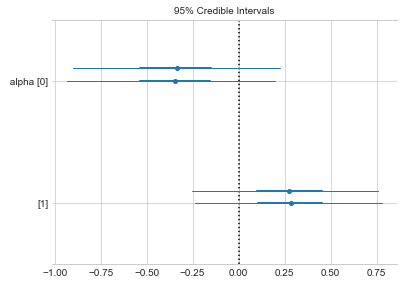

In [13]:
pm.forestplot(model_j.trace, varnames=['alpha'], rhat=False)
None

**single interaction, flight vs wine**

In [12]:
with pm.Model() as model_fw:
    beta = pm.Normal('beta', mu=0, sd=1, shape=(2, 2))

    score = pm.Deterministic(
        'score',
        train.score.mean()
        + beta[train.wine_amer.values, train.flight_red.values]
    )

    score_test = pm.Deterministic(
        'score_test',
        train.score.mean()
        + beta[test.wine_amer.values, test.flight_red.values]
    )

    score_sigma = pm.HalfCauchy('sigma', 10)
    score_obs = pm.Normal('score_obs', mu=score, sd=score_sigma,
                          observed=train.score.values)

    model_fw.name = 'wine vs flight'
    model_fw.trace = pm.sample(5000, tune=1500, chains=2)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]
Sampling 2 chains: 100%|██████████| 13000/13000 [00:1

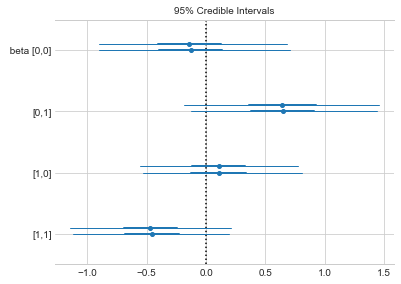

In [14]:
pm.forestplot(model_fw.trace, varnames=['beta'], rhat=False)
None

**interaction + judge**

In [15]:
with pm.Model() as model_fw_j:
    beta = pm.Normal('beta', mu=0, sd=1, shape=(2, 2))
    beta_j = pm.Normal('beta_j', mu=0, sd=1, shape=2)

    score = pm.Deterministic(
        'score',
        train.score.mean()
        + beta[train.wine_amer.values, train.flight_red.values]
        + beta_j[train.judge_amer.values]
    )

    score_test = pm.Deterministic(
        'score_test',
        train.score.mean()
        + beta[test.wine_amer.values, test.flight_red.values]
        + beta_j[test.judge_amer.values]
    )
    
    score_sigma = pm.HalfCauchy('sigma', 10)
    score_obs = pm.Normal('score_obs', mu=score, sd=score_sigma,
                          observed=train.score.values)

    model_fw_j.name = 'wine vs flight & judge'
    model_fw_j.trace = pm.sample(5000, tune=1500, chains=2)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_j, beta]
/home/petrushev/etc/jup_env/lib/python3.7/sit

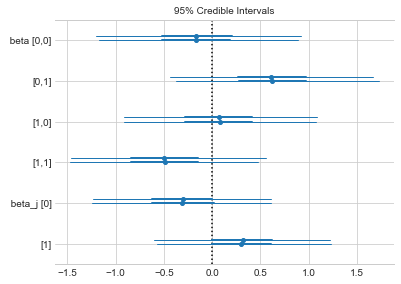

In [17]:
pm.forestplot(model_fw_j.trace, varnames=['beta', 'beta_j'], rhat=False)
None

---

**comparison**

In [19]:
comparison = pm.compare({
        model_j: model_j.trace,
        model_fw: model_fw.trace,
        model_fw_j: model_fw_j.trace,
    },
    method='BB-pseudo-BMA'
)

comparison

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
wine vs flight & judge,865.02,5.04,0,0.35,16.69,0,0
judges,865.44,2.7,0.42,0.36,17.07,4.08,0
wine vs flight,865.92,4.07,0.89,0.29,16.04,3.2,0


**ensemble model**

In [20]:
nsamples = (comparison.weight / comparison.weight.max() * 10000).astype('int')
nsamples.to_frame()

,weight
wine vs flight & judge,9722
judges,10000
wine vs flight,8055


In [27]:
mix = pd.concat([
    pd.DataFrame(model_j.trace['score_test']).sample(nsamples['judges']),
    pd.DataFrame(model_fw.trace['score_test']).sample(nsamples['wine vs flight']),
    pd.DataFrame(model_fw_j.trace['score_test']).sample(nsamples['wine vs flight & judge']),

], ignore_index=True)#.stack().rename('score_pred').reset_index()

mix = agg_prediction(mix, test,
                     ['wine_amer', 'judge_amer', 'flight_red'],
                     summarize())


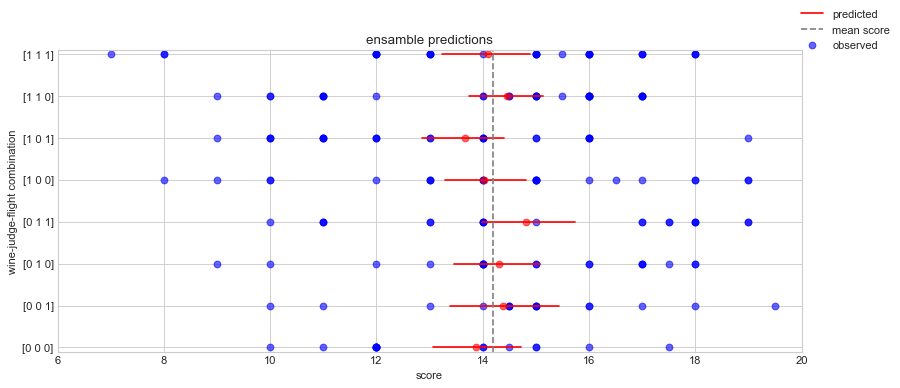

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5), dpi=80)

labels = []

for ix, row in mix.iterrows():
    tmp_true = train[(train.wine_amer == row.wine_amer)
                     & (train.judge_amer == row.judge_amer)
                     & (train.flight_red == row.flight_red)]

    obs = ax.scatter(tmp_true.score, np.ones(tmp_true.shape[0]) * ix, c='b', alpha=.6)

    pred = ax.plot((row.lower, row.upper), (ix, ix), c='r')
    ax.scatter(row.mean_, ix, c='r', alpha=.6)
    
    label = (np.array([row.wine_amer, row.judge_amer, row.flight_red])).astype('int')
    labels.append(label)
    
obs.set_label('observed')
pred[0].set_label('predicted')

ax.axvline(train.score.mean(), label='mean score', c='grey', linestyle='--')
    
ax.set(
    xlabel='score', ylabel='wine-judge-flight combination',
    xlim=(6, 20), title='ensamble predictions', ylim=(-0.1, 7.1),
    yticks=range(8),yticklabels=labels
)

fig.legend()
None